<a href="https://colab.research.google.com/github/shahendaelsawi/amit_diploma/blob/main/tomato_disease_classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing libraries
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from PIL import ImageFile

# checking availability of GPUs/TPUs
ImageFile.LOAD_TRUNCATED_IMAGES = True
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## The Idea Behind Inception & Residual Layers
![ResBlock](https://miro.medium.com/max/570/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)
![InceptionModule](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/Screenshot-from-2018-10-17-11-14-10.png)

## Originial InceptionV1 Net
![Inception Network](https://miro.medium.com/max/1400/1*uW81y16b-ptBDV8SIT1beQ.png)

In [ ]:
# Define a residual block to avoid vanishing gradients
def ResBlock(ip: tf.keras.layers.Layer,
             x: tf.Tensor):
    return tf.keras.layers.Add()([x, ip(x)])

# Define an inception layer
def InceptionLayer(x: tf.Tensor):
    a = tf.keras.layers.Conv2D(64, (1,1))(x)
    b = tf.keras.layers.Conv2D(64, (1,1))(x)
    c = tf.keras.layers.Conv2D(64, (1,1))(x)
    d = tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same')(x)
    c = tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same')(c)
    a = tf.keras.layers.Conv2D(64, (5,5),
                               padding='same', strides=(2,2))(a)
    b = tf.keras.layers.Conv2D(64, (3,3),
                              padding='same',strides=(2,2))(b)
    d = tf.keras.layers.Conv2D(64, (1,1))(d)
    op = tf.concat([a,b,c,d], -1)
    return op

# Stem of InResNet
def NetStem(x: tf.Tensor):
    x = tf.keras.layers.Conv2D(16, (3,3))(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, (3,3))(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

# My very own -probably not working- net.
def InResNet(x: tf.Tensor):
    x = NetStem(x)
    for i in range(4):
        x = InceptionLayer(x)
        x = InceptionLayer(x)
        x = ResBlock(tf.keras.layers.Conv2D(x.shape[-1],(1,1)),x)
    x = InceptionLayer(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    return tf.keras.layers.Dense(11, activation='softmax')(x)

In [ ]:
# instantiating the model
tf.keras.backend.clear_session()
ip = tf.keras.layers.Input(shape=(200,200,3))
op = InResNet(ip)
compile_params = {
    "optimizer" : tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
    "loss" : 'categorical_crossentropy', 
    "metrics" : ['accuracy']
}
model = tf.keras.Model(ip,op)
model.compile(**compile_params)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 198, 198, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 198, 198, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 99, 99, 16)   0           activation[0][0]                 
______________________________________________________________________________________________

## InResNet
![InResNet](./gnet.jpeg "Gawishian Net")

In [ ]:
# preparing generators for preprocessing and loading the data
train_preproc = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rotation_range=90,
                                                                brightness_range=[0, 1],
                                                                validation_split=0.1)
test_preproc = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_data = train_preproc.flow_from_directory(
    "/kaggle/input/tomato-disease-multiple-sources/train/",
    target_size=(100,100),
    batch_size=16,
    subset="training",
    shuffle=True
)
val_data = train_preproc.flow_from_directory(
    "/kaggle/input/tomato-disease-multiple-sources/train/",
    subset="validation",
    shuffle=True,
    batch_size=16,
    target_size=(100,100)
)
test_data = test_preproc.flow_from_directory(
    "/kaggle/input/tomato-disease-multiple-sources/valid/",
    target_size=(100,100)
)

Found 23271 images belonging to 11 classes.
Found 2580 images belonging to 11 classes.
Found 6684 images belonging to 11 classes.


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# a call back to terminate training when reaching certain accuracy
class StopTraining(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        self.THRESHOLD = threshold
    def on_epoch_end(self, epoch, logs={}):
        try:
            if(logs.get('accuracy') >= self.THRESHOLD):  
                    self.model.stop_training = True
        except TypeError: pass

# learning rate decay function
def alpha_decay(epoch, alpha):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return alpha * pow(decay_rate, np.floor(epoch / decay_step))
    return alpha

# training parameters
epochs = 1000
steps = 50
callbacks = [StopTraining(0.9),
             LearningRateScheduler(alpha_decay, verbose=1)]

# normal training of the model:
history_1 = model.fit(train_data,
          steps_per_epoch=steps,
          epochs=epochs,
          callbacks=callbacks[0:1],
          verbose=0,
          validation_data=val_data,
          validation_steps=10)

# adaptive second training of the model:
history_2 = model.fit(train_data,
          steps_per_epoch=steps,
          epochs=epochs//5,
          callbacks=callbacks,
          validation_data=val_data,
          validation_steps=10)

2023-01-01 23:52:03.078026: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-01 23:52:03.082115: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz
2023-01-01 23:52:08.327067: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-01-01 23:52:09.182148: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-01-01 23:52:09.229473: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


Epoch 1/200

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
50/50 [==============================] - 6s 126ms/step - loss: 0.3835 - accuracy: 0.8938 - val_loss: 0.2916 - val_accuracy: 0.9312
Epoch 2/200

Epoch 00002: LearningRateScheduler reducing learning rate to 8.499999785271939e-05.
50/50 [==============================] - 6s 111ms/step - loss: 0.3556 - accuracy: 0.8863 - val_loss: 0.3611 - val_accuracy: 0.8562
Epoch 3/200

Epoch 00003: LearningRateScheduler reducing learning rate to 6.14124997628096e-05.
50/50 [==============================] - 6s 110ms/step - loss: 0.4304 - accuracy: 0.8650 - val_loss: 0.2247 - val_accuracy: 0.9187
Epoch 4/200

Epoch 00004: LearningRateScheduler reducing learning rate to 3.771495276851055e-05.
50/50 [==============================] - 6s 128ms/step - loss: 0.3715 - accuracy: 0.8775 - val_loss: 0.2499 - val_accuracy: 0.9062
Epoch 5/200

Epoch 00005: LearningRateScheduler reducing learning rate to 1.9687440536631

In [ ]:
# test accuracy & loss
model.evaluate(test_data)

209/209 [==============================] - 73s 348ms/step - loss: 0.5226 - accuracy: 0.8580


[0.5226033329963684, 0.8580191731452942]

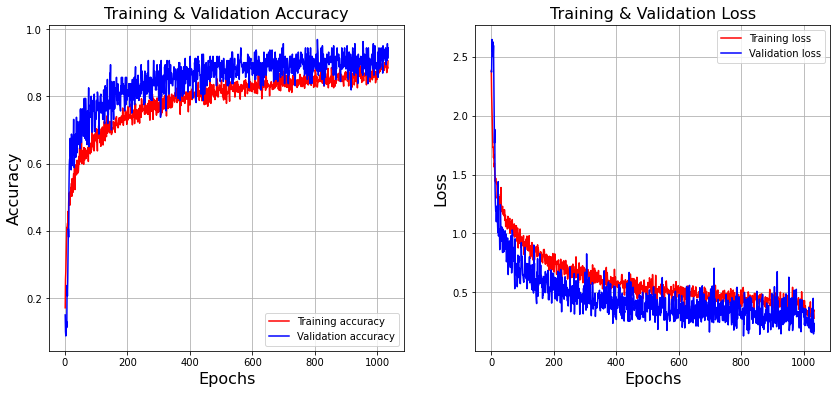

In [ ]:
# getting the training data from histories
history1_dict = history_1.history
history2_dict = history_2.history
loss_values = history1_dict['loss']+history2_dict['loss']
val_loss_values = history1_dict['val_loss']+history2_dict['val_loss']
accuracy = history1_dict['accuracy']+history2_dict['accuracy']
val_accuracy = history1_dict['val_accuracy']+history2_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
ax[0].grid("on")

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()
ax[1].grid("on");

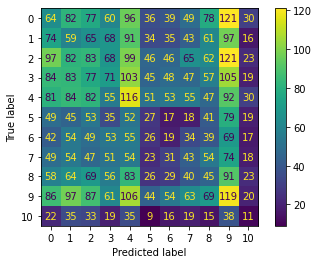

In [ ]:
# plotting the confusion matrix for the model:
from sklearn import metrics
y_pred = [np.argmax(img) for img in model.predict(test_data)]
confusion_matrix = metrics.confusion_matrix(test_data.labels,y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot();